In [ ]:
!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
import sys; sys.path.append('./stepik-dl-nlp')

In [3]:
%load_ext autoreload
%autoreload 2

import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils
from dlnlputils.data import tokenize_corpus, build_vocabulary, texts_to_token_ids, \
    PaddedSequenceDataset, Embeddings
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed
from dlnlputils.visualization import plot_vectors

init_random_seed()

# Word2Vec 

## def func

In [234]:
class SkipGramNegativeSamplingTrainer(nn.Module):
    def __init__(self, vocab_size, emb_size, sentence_len, radius=5, negative_samples_n=5):
        super().__init__()
        self.vocab_size = vocab_size
        self.negative_samples_n = negative_samples_n

        self.center_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)
        self.center_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.center_emb.weight.data[0] = 0

        self.context_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)        
        self.context_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.context_emb.weight.data[0] = 0

        self.positive_sim_mask = make_diag_mask(sentence_len, radius)
    
    def forward(self, sentences):
        """sentences - Batch x MaxSentLength - идентификаторы токенов"""
        batch_size = sentences.shape[0]
        center_embeddings = self.center_emb(sentences)  # Batch x MaxSentLength x EmbSize

        # оценить сходство с настоящими соседними словами
        positive_context_embs = self.context_emb(sentences).permute(0, 2, 1)  # Batch x EmbSize x MaxSentLength
        positive_sims = torch.bmm(center_embeddings, positive_context_embs)  # Batch x MaxSentLength x MaxSentLength
        positive_probs = torch.sigmoid(positive_sims)

        # увеличить оценку вероятности встретить эти пары слов вместе
        positive_mask = self.positive_sim_mask.to(positive_sims.device)
        positive_loss = F.binary_cross_entropy(positive_probs * positive_mask,
                                               positive_mask.expand_as(positive_probs))

        # выбрать случайные "отрицательные" слова
        negative_words = torch.randint(1, self.vocab_size,
                                       size=(batch_size, self.negative_samples_n),
                                       device=sentences.device)  # Batch x NegSamplesN
        negative_context_embs = self.context_emb(negative_words).permute(0, 2, 1)  # Batch x EmbSize x NegSamplesN
        negative_sims = torch.bmm(center_embeddings, negative_context_embs)  # Batch x MaxSentLength x NegSamplesN
        
        # уменьшить оценку вероятность встретить эти пары слов вместе
        negative_loss = F.binary_cross_entropy_with_logits(negative_sims,
                                                           negative_sims.new_zeros(negative_sims.shape))

        return positive_loss + negative_loss


def no_loss(pred, target):
    """Фиктивная функция потерь - когда модель сама считает функцию потерь"""
    return pred

In [235]:
def make_diag_mask(size, radius):
    """Квадратная матрица размера Size x Size с двумя полосами ширины radius вдоль главной диагонали"""
    idxs = torch.arange(size)
    abs_idx_diff = (idxs.unsqueeze(0) - idxs.unsqueeze(1)).abs()
    mask = ((abs_idx_diff <= radius) & (abs_idx_diff > 0)).float()
    return mask

## data processing

In [236]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
full_dataset = list(pd.read_csv('./stepik-dl-nlp/datasets/nyt-ingredients-snapshot-2015.csv')['input'].dropna())
random.shuffle(full_dataset)

TRAIN_VAL_SPLIT = int(len(full_dataset) * 0.7)
train_source = full_dataset[:TRAIN_VAL_SPLIT]
test_source = full_dataset[TRAIN_VAL_SPLIT:]
print("Обучающая выборка", len(train_source))
print("Тестовая выборка", len(test_source))
print()
print('\n'.join(train_source[:10]))

Обучающая выборка 125344
Тестовая выборка 53719

1/2 teaspoon salt, plus more to taste
1 tablespoon kosher salt
1 quart duck broth
2 cups leftover mashed potatoes (from about 2 pounds potatoes), cooled
Salt to taste
2 tablespoons cracked black pepper
1 tablespoon honey
3 to 4 tablespoons flour
3 mint leaves (or another soft herb, or additional basil)
1/4 pound golden oak mushrooms


In [237]:
# токенизируем
train_tokenized = tokenize_corpus(train_source)
test_tokenized = tokenize_corpus(test_source)
print('\n'.join(' '.join(sent) for sent in train_tokenized[:10]))

teaspoon salt plus more taste
tablespoon kosher salt
quart duck broth
cups leftover mashed potatoes from about pounds potatoes cooled
salt taste
tablespoons cracked black pepper
tablespoon honey
tablespoons flour
mint leaves another soft herb additional basil
pound golden mushrooms


In [238]:
# строим словарь
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=0.9, min_count=5, pad_word='<PAD>')
print("Размер словаря", len(vocabulary))
print(list(vocabulary.items())[:10])

Размер словаря 2263
[('<PAD>', 0), ('tablespoons', 1), ('teaspoon', 2), ('chopped', 3), ('salt', 4), ('pepper', 5), ('cups', 6), ('ground', 7), ('tablespoon', 8), ('fresh', 9)]


In [239]:
# отображаем в номера токенов
train_token_ids = texts_to_token_ids(train_tokenized, vocabulary)
test_token_ids = texts_to_token_ids(test_tokenized, vocabulary)

print('\n'.join(' '.join(str(t) for t in sent)
                for sent in train_token_ids[:10]))

2 4 45 47 10
8 57 4
314 348 100
6 722 477 93 139 24 25 93 508
4 10
1 395 22 5
8 173
1 38
128 33 782 319 679 285 87
12 367 113


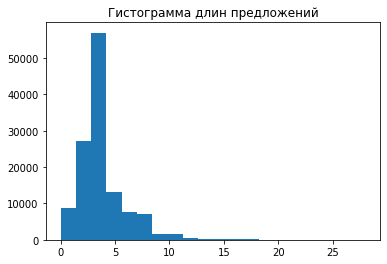

In [240]:
plt.hist([len(s) for s in train_token_ids], bins=20);
plt.title('Гистограмма длин предложений');

In [241]:
MAX_SENTENCE_LEN = 20
train_dataset = PaddedSequenceDataset(train_token_ids,
                                      np.zeros(len(train_token_ids)),
                                      out_len=MAX_SENTENCE_LEN)
test_dataset = PaddedSequenceDataset(test_token_ids,
                                     np.zeros(len(test_token_ids)),
                                     out_len=MAX_SENTENCE_LEN)
print(train_dataset[0])

(tensor([ 2,  4, 45, 47, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0]), tensor(0))


## best model

In [258]:
trainer = SkipGramNegativeSamplingTrainer(len(vocabulary), 100, MAX_SENTENCE_LEN,
                                          radius=5, negative_samples_n=30)

In [259]:
best_val_loss, best_model = train_eval_loop(trainer,
                                            train_dataset,
                                            test_dataset,
                                            no_loss,
                                            lr=1e-2,
                                            epoch_n=10,
                                            batch_size=10,
                                            device='cuda',
                                            early_stopping_patience=10,
                                            max_batches_per_epoch_train=2000,
                                            max_batches_per_epoch_val=len(test_dataset),
                                            lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=1, verbose=True))

Эпоха 0
Эпоха: 2001 итераций, 4.91 сек
Среднее значение функции потерь на обучении 0.8875559070657218
Среднее значение функции потерь на валидации 0.8797402788433493
Новая лучшая модель!

Эпоха 1
Эпоха: 2001 итераций, 4.94 сек
Среднее значение функции потерь на обучении 0.8780048510421817
Среднее значение функции потерь на валидации 0.8759672661614968
Новая лучшая модель!

Эпоха 2
Эпоха: 2001 итераций, 4.97 сек
Среднее значение функции потерь на обучении 0.8750262677163139
Среднее значение функции потерь на валидации 0.874905983015218
Новая лучшая модель!

Эпоха 3
Эпоха: 2001 итераций, 4.87 сек
Среднее значение функции потерь на обучении 0.8738063894945761
Среднее значение функции потерь на валидации 0.8751114822663395

Эпоха 4
Эпоха: 2001 итераций, 4.95 сек
Среднее значение функции потерь на обучении 0.8743369539697905
Среднее значение функции потерь на валидации 0.8748987827031185
Новая лучшая модель!
Epoch     5: reducing learning rate of group 0 to 1.0000e-03.

Эпоха 5
Эпоха: 2001 

## results

In [260]:
embeddings = Embeddings(trainer.center_emb.weight.detach().cpu().numpy(), vocabulary)

In [261]:
embeddings.most_similar('chicken')

[('chicken', 0.9999368),
 ('turkey', 0.63791496),
 ('thighs', 0.6275583),
 ('broth', 0.61908716),
 ('duck', 0.60757655),
 ('breast', 0.58227134),
 ('stock', 0.57310545),
 ('breasts', 0.5377855),
 ('capon', 0.53512955),
 ('drumsticks', 0.52764225)]

In [262]:
embeddings.analogy('cake', 'cacao', 'cheese')

[('cacao', 0.9361325),
 ('cheese', 0.8831937),
 ('bittersweet', 0.77585536),
 ('percent', 0.7611739),
 ('cotija', 0.7171925),
 ('gruyère', 0.7145411),
 ('fontina', 0.7109932),
 ('chocolate', 0.6931756),
 ('gorgonzola', 0.6906317),
 ('stilton', 0.67771685)]

In [263]:
test_words = ['salad', 'fish', 'salmon', 'sauvignon', 'beef', 'pork', 'steak', 'beer', 'cake', 'coffee', 'sausage', 'wine', 'merlot', 'zinfandel', 'trout', 'chardonnay', 'champagne', 'cacao']
test_vectors = embeddings.get_vectors(*test_words)
print(test_vectors.shape)

(18, 100)


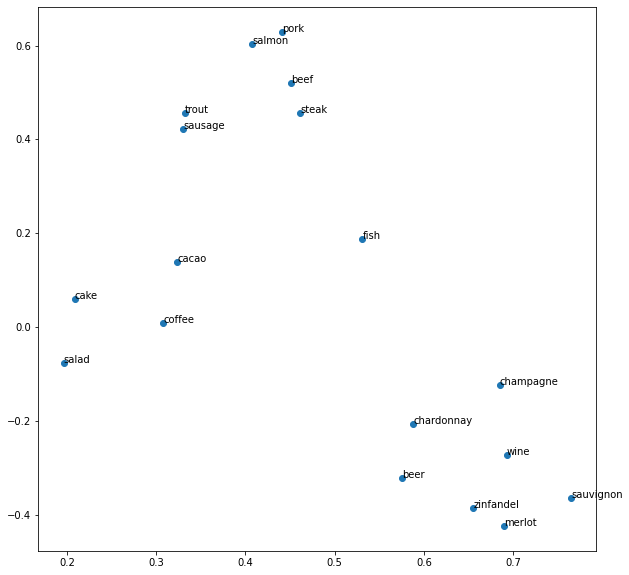

In [264]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(test_vectors, test_words, how='svd', ax=ax)

# FastText

## def func

In [265]:
def build_vocabulary_fasttext(tokenized_texts, max_size=1000000, max_doc_freq=0.8, min_count=5, pad_word=None, min_n=3, max_n=6):
    import collections

    def generate_n_gram(words):
        result = []
        result_buf = [[word[j:j+i] for i in range(min_n, max_n+1) if len(word) > i for j in range(len(word)-i+1)] for word in words]
        for i in result_buf:
            result += i
        result = list(set(result))
        return [f"#{i}" for i in result]
    
    word_counts = collections.defaultdict(int)
    doc_n = 0

    # посчитать количество документов, в которых употребляется каждое слово
    # а также общее количество документов
    for txt in tokenized_texts:
        doc_n += 1
        unique_text_tokens = list(set(txt))
        # unique_text_tokens += generate_n_gram(unique_text_tokens)
        for token in unique_text_tokens:
            word_counts[token] += 1

    # убрать слишком редкие и слишком частые слова
    word_counts = {word: cnt for word, cnt in word_counts.items()
                   if cnt >= min_count and cnt / doc_n <= max_doc_freq}

    # отсортировать слова по убыванию частоты
    sorted_word_counts = sorted(word_counts.items(),
                                reverse=True,
                                key=lambda pair: pair[1])

    # добавим несуществующее слово с индексом 0 для удобства пакетной обработки
    if pad_word is not None:
        sorted_word_counts = [(pad_word, 0)] + sorted_word_counts

    # если у нас по прежнему слишком много слов, оставить только max_size самых частотных
    if len(word_counts) > max_size:
        sorted_word_counts = sorted_word_counts[:max_size]
    
    # нумеруем слова
    word2id = {word: i for i, (word, _) in enumerate(sorted_word_counts)}

    subword_counts = collections.defaultdict(int)
    for txt in tokenized_texts:
        unique_text_tokens = list(set(txt))
        # unique_text_tokens += generate_n_gram(unique_text_tokens)
        for token in unique_text_tokens:
            if token not in word2id:
                continue
            if word2id[token] == 0:
                continue
            subword = generate_n_gram([token])
            for i in subword:
                subword_counts[i] += 1

    subword_counts = {word: cnt for word, cnt in subword_counts.items()
                      if cnt >= min_count and cnt / doc_n <= max_doc_freq}
    sorted_subword_counts = sorted(subword_counts.items(),
                                   reverse=True,
                                   key=lambda pair: pair[1])
    if len(subword_counts) > max_size:
        sorted_subword_counts = sorted_subword_counts[:max_size]
    
    subword_idx = len(word2id)
    subword2id = {word: i+subword_idx for i, (word, _) in enumerate(sorted_subword_counts)}
    word2id.update(subword2id)

    # нормируем частоты слов
    word2freq = np.array([cnt / doc_n for _, cnt in sorted_word_counts], dtype='float32')

    token2subwords = {word2id[word] : [word2id[i] for i in generate_n_gram([word]) if i in word2id] for word in word2id if word[0] != '#'}

    return word2id, word2freq, token2subwords, subword_idx

In [266]:
class SkipGramNegativeSamplingTrainer_fasttext(nn.Module):
    def __init__(self, vocab_size, emb_size, sentence_len, token2subwords, radius=5, negative_samples_n=5):
        super().__init__()
        self.token2subwords = token2subwords
        self.vocab_size = vocab_size
        self.negative_samples_n = negative_samples_n

        self.center_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)
        self.center_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.center_emb.weight.data[0] = 0

        self.context_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)        
        self.context_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.context_emb.weight.data[0] = 0

        self.positive_sim_mask = make_diag_mask(sentence_len, radius)
    
    def forward(self, sentences):
        """sentences - Batch x MaxSentLength - идентификаторы токенов"""
        batch_size = sentences.shape[0]
        center_embeddings = self.center_emb(sentences)  # Batch x MaxSentLength x EmbSize

        for i_sample in range(sentences.shape[0]):
            for i_token in range(sentences.shape[1]):
                if int(sentences[i_sample][i_token]) == 0:
                    continue
                if int(sentences[i_sample][i_token]) not in self.token2subwords:
                    continue
                subwords = self.token2subwords[int(sentences[i_sample][i_token])]
                if not subwords:
                    continue
                subwords_embeddings = self.center_emb(torch.Tensor(subwords).type(torch.cuda.LongTensor))
                center_embeddings[i_sample][i_token] = torch.div(torch.add(center_embeddings[i_sample][i_token], subwords_embeddings.mean(0)), 2.0)

        # оценить сходство с настоящими соседними словами
        positive_context_embs = self.context_emb(sentences).permute(0, 2, 1)  # Batch x EmbSize x MaxSentLength
        positive_sims = torch.bmm(center_embeddings, positive_context_embs)  # Batch x MaxSentLength x MaxSentLength
        positive_probs = torch.sigmoid(positive_sims)

        # увеличить оценку вероятности встретить эти пары слов вместе
        positive_mask = self.positive_sim_mask.to(positive_sims.device)
        positive_loss = F.binary_cross_entropy(positive_probs * positive_mask,
                                               positive_mask.expand_as(positive_probs))

        # выбрать случайные "отрицательные" слова
        negative_words = torch.randint(1, self.vocab_size,
                                       size=(batch_size, self.negative_samples_n),
                                       device=sentences.device)  # Batch x NegSamplesN
        negative_context_embs = self.context_emb(negative_words).permute(0, 2, 1)  # Batch x EmbSize x NegSamplesN
        negative_sims = torch.bmm(center_embeddings, negative_context_embs)  # Batch x MaxSentLength x NegSamplesN
        
        # уменьшить оценку вероятность встретить эти пары слов вместе
        negative_loss = F.binary_cross_entropy_with_logits(negative_sims,
                                                           negative_sims.new_zeros(negative_sims.shape))

        return positive_loss + negative_loss


def no_loss(pred, target):
    """Фиктивная функция потерь - когда модель сама считает функцию потерь"""
    return pred

## data processing

In [267]:
full_dataset = list(pd.read_csv('./stepik-dl-nlp/datasets/nyt-ingredients-snapshot-2015.csv')['input'].dropna())
random.shuffle(full_dataset)

TRAIN_VAL_SPLIT = int(len(full_dataset) * 0.7)
train_source = full_dataset[:TRAIN_VAL_SPLIT]
test_source = full_dataset[TRAIN_VAL_SPLIT:]
print("Обучающая выборка", len(train_source))
print("Тестовая выборка", len(test_source))
print()
print('\n'.join(train_source[:10]))

Обучающая выборка 125344
Тестовая выборка 53719

1 pound medium potatoes, like yellow gold, Washington or Idaho
3 scallions, trimmed and chopped
1 medium onion, finely chopped
Kosher salt, as needed
Fresh tarragon leaves
3/4 pound mushrooms, trimmed and diced
1 1/2 to 2 tablespoons tomato paste
2 sprigs fresh thyme or 1/2 teaspoon dried
4 peaches, halved and pitted
1 teaspoon olive oil


In [268]:
# токенизируем
train_tokenized = tokenize_corpus(train_source)
test_tokenized = tokenize_corpus(test_source)
print('\n'.join(' '.join(sent) for sent in train_tokenized[:10]))

pound medium potatoes like yellow gold washington idaho
scallions trimmed chopped
medium onion finely chopped
kosher salt needed
fresh tarragon leaves
pound mushrooms trimmed diced
tablespoons tomato paste
sprigs fresh thyme teaspoon dried
peaches halved pitted
teaspoon olive


In [269]:
# строим словарь
vocabulary, word_doc_freq, token2subwords, subword_idx = build_vocabulary_fasttext(train_tokenized, max_doc_freq=0.9, min_count=5, pad_word='<PAD>')
print("Размер словаря", len(vocabulary))
print(list(vocabulary.items())[:30])

Размер словаря 15916
[('<PAD>', 0), ('tablespoons', 1), ('teaspoon', 2), ('chopped', 3), ('salt', 4), ('pepper', 5), ('cups', 6), ('ground', 7), ('tablespoon', 8), ('fresh', 9), ('taste', 10), ('freshly', 11), ('pound', 12), ('olive', 13), ('garlic', 14), ('peeled', 15), ('finely', 16), ('teaspoons', 17), ('minced', 18), ('large', 19), ('butter', 20), ('ounces', 21), ('black', 22), ('sugar', 23), ('about', 24), ('pounds', 25), ('sliced', 26), ('juice', 27), ('into', 28), ('white', 29)]


In [270]:
# отображаем в номера токенов
train_token_ids = texts_to_token_ids(train_tokenized, vocabulary)
test_token_ids = texts_to_token_ids(test_tokenized, vocabulary)

print('\n'.join(' '.join(str(t) for t in sent)
                for sent in train_token_ids[:10]))

12 36 90 147 140 431 1464 544
93 73 3
36 33 16 3
58 4 135
9 204 34
12 113 73 49
1 120 158
82 9 63 2 43
535 119 173
2 13


In [271]:
MAX_SENTENCE_LEN = 20
train_dataset = PaddedSequenceDataset(train_token_ids,
                                      np.zeros(len(train_token_ids)),
                                      out_len=MAX_SENTENCE_LEN)
test_dataset = PaddedSequenceDataset(test_token_ids,
                                     np.zeros(len(test_token_ids)),
                                     out_len=MAX_SENTENCE_LEN)
print(train_dataset[0])

(tensor([  12,   36,   90,  147,  140,  431, 1464,  544,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]), tensor(0))


## best model

In [272]:
trainer_ft = SkipGramNegativeSamplingTrainer_fasttext(len(vocabulary), 100, MAX_SENTENCE_LEN, token2subwords,
                                                   radius=5, negative_samples_n=30)

In [273]:
best_val_loss, best_model = train_eval_loop(trainer_ft,
                                            train_dataset,
                                            test_dataset,
                                            no_loss,
                                            lr=9e-3,
                                            epoch_n=10,
                                            batch_size=10,
                                            device='cuda',
                                            early_stopping_patience=10,
                                            max_batches_per_epoch_train=2000,
                                            max_batches_per_epoch_val=len(test_dataset),

                                            lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=1, verbose=True))

Эпоха 0
Эпоха: 2001 итераций, 68.51 сек
Среднее значение функции потерь на обучении 0.8652459300499686
Среднее значение функции потерь на валидации 0.8550764942959184
Новая лучшая модель!

Эпоха 1
Эпоха: 2001 итераций, 68.95 сек
Среднее значение функции потерь на обучении 0.8531568174300225
Среднее значение функции потерь на валидации 0.8529351842509928
Новая лучшая модель!

Эпоха 2
Эпоха: 2001 итераций, 69.06 сек
Среднее значение функции потерь на обучении 0.8520872376669293
Среднее значение функции потерь на валидации 0.8518431064071534
Новая лучшая модель!

Эпоха 3
Эпоха: 2001 итераций, 69.61 сек
Среднее значение функции потерь на обучении 0.8502469174508034
Среднее значение функции потерь на валидации 0.8517818017096459
Новая лучшая модель!

Эпоха 4
Эпоха: 2001 итераций, 69.22 сек
Среднее значение функции потерь на обучении 0.8494837748474148
Среднее значение функции потерь на валидации 0.851544262742872
Новая лучшая модель!

Эпоха 5
Эпоха: 2001 итераций, 69.07 сек
Среднее значение

## results

In [274]:
# embeddings = Embeddings(trainer_ft.center_emb.weight.detach().cpu().numpy(), vocabulary)

vocabulary_without_subword = {k : vocabulary[k] for k in vocabulary if vocabulary[k] < subword_idx}
weight_without_subword = trainer_ft.center_emb.weight.detach().cpu().numpy()[:subword_idx]
embeddings = Embeddings(weight_without_subword, vocabulary_without_subword)

In [275]:
embeddings.most_similar('chicken')

[('chicken', 0.99994564),
 ('duck', 0.6059493),
 ('stock', 0.6051731),
 ('breasts', 0.5995306),
 ('broth', 0.5564983),
 ('skinless', 0.5235989),
 ('turkey', 0.52202076),
 ('veal', 0.514833),
 ('beef', 0.5082549),
 ('boneless', 0.49188977)]

In [276]:
embeddings.analogy('cake', 'cacao', 'cheese')

[('cacao', 1.1598519),
 ('cheese', 0.7774274),
 ('gruyère', 0.71127063),
 ('mozzarella', 0.69770014),
 ('rennet', 0.6839302),
 ('cotija', 0.65238994),
 ('gouda', 0.6471017),
 ('slab', 0.64538276),
 ('farmer', 0.6325748),
 ('bittersweet', 0.6236005)]

In [277]:
test_words = ['salad', 'fish', 'salmon', 'sauvignon', 'beef', 'pork', 'steak', 'beer', 'cake', 'coffee', 'sausage', 'wine', 'merlot', 'zinfandel', 'trout', 'chardonnay', 'champagne', 'cacao']
test_vectors = embeddings.get_vectors(*test_words)
print(test_vectors.shape)

(18, 100)


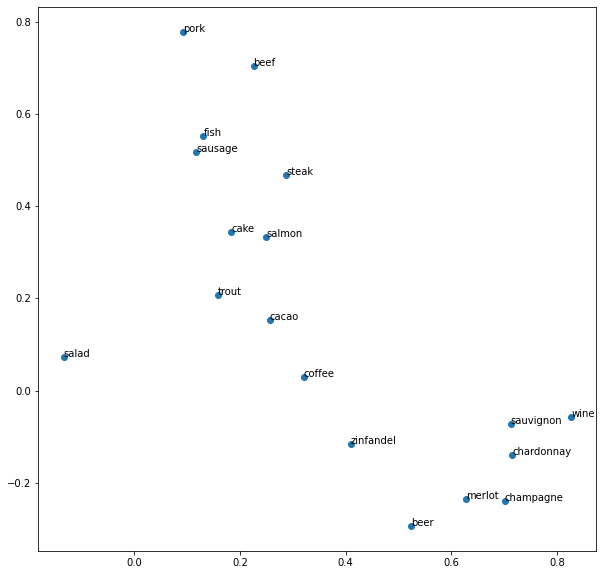

In [278]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(test_vectors, test_words, how='svd', ax=ax)

# FastText (Gensim)

In [229]:
import gensim

In [230]:
word2vec = gensim.models.FastText(sentences=train_tokenized, size=100,
                                  window=5, min_count=5, workers=4,
                                  sg=1, iter=10)

In [231]:
word2vec.wv.most_similar('chicken')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('chickens', 0.9146710634231567),
 ('chick', 0.831925630569458),
 ('drumstick', 0.7516579627990723),
 ('duck', 0.7484409809112549),
 ('turkey', 0.7366585731506348),
 ('thighs', 0.7172189950942993),
 ('muscovy', 0.7136343121528625),
 ('drumsticks', 0.7080140113830566),
 ('quail', 0.6909353733062744),
 ('breasts', 0.6872392296791077)]

In [232]:
gensim_words = [w for w in test_words if w in word2vec.wv.vocab]
gensim_vectors = np.stack([word2vec.wv[w] for w in gensim_words])

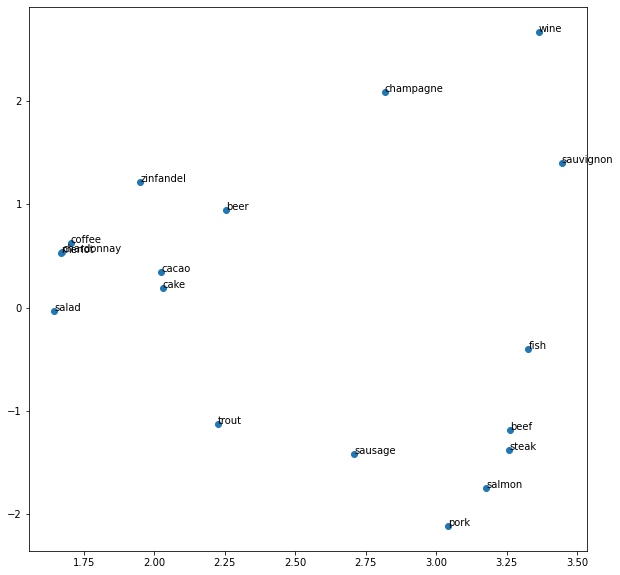

In [233]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(gensim_vectors, test_words, how='svd', ax=ax)